## Progress Report.

Goal: Explain the work that has been done and the next planned steps.

### Description of Project:

A paper describes five models of public support for European Integration (http://www.jstor.org/stable/pdf/2647912.pdf):

* Cognitive Mobilization
* Political Values
* Utilitarian Appraisals of Integrative Policy
* Class Partisanship
* Support for Government

My goal is to recreate its results in a modern programming lanugage and then use the code created for that to replicate the work on subsequent Eurobarometer polls.

Possible findings:
* Have the order of support for the differet models changed since 1998.
* Are there differences between the various expansion counties, and do they differ significantly from the longer-term members. 
* Did the implementation of the Euro have an impact on the different models?


#### Getting access to the data.

All eurobarometer polls are available for download from the GESIS – Leibniz Institute for the Social Sciences. 

They have a number of tools to help with using the data: 

* [Question Search](http://www.gesis.org/eurobarometer-data-service/search-data-access/question-retrieval/)
* [Data Browser](http://zacat.gesis.org/webview/index.jsp?object=http://zacat.gesis.org/obj/fStudy/ZA1715)

All the Datasets, questionaires, and code books are available here. An important thing to note is that while the questions within a poll are numbered, these are not the numbers assigned to the variables within the data set, so without all the parts the datasets themselves would be of very limited use. Within the text when refering to a question I do so by variable name, vXXX. 

#### A note on the tools.

I will be writing in Python, but using a number of tools to help me along. 

* Jupyter Notebook http://jupyter.org/
* The Pandas Data Analysis Library: http://pandas.pydata.org/
* Statsmodel: http://www.statsmodels.org/
* These projects make heavy use of the numpy project: http://www.numpy.org/

As the tools themselves provide quite highlevel abstractions, I'm hoping that the resulting code will be of a fairly straightforward and readable nature. (This may or may not turn out to be true.)

At least initially I will be deliberately avoiding 'clever' code. If I can do something four times and it's clear, or once and it's obscure, I'll be doing it four times. In an envrionment where performance or maintainability was important this would be wrong, but I feel in this project where I am aiming for correctness it is the right approach. 

To provide me with some peace of mind with regards backups/revision control I'll be hosting the code on https://gitlab.com/tdeburca/thesis 

To avoid accidentally having the project scraped by 'Turn It in' the project is currently private. If you would like access to it I can grant you access via an account tied to your DCU identity. 


#### Initializing Notebook

This report has been provided to you as a PDF, but originated as a web page where all the code and be edited and run interactively. To allow that to work it must include the following stanza. 

In [1]:
%pylab inline
# Allow inline Images. 
from IPython.display import Image 

import pandas
import numpy as np
# For Weighted Correlation
from statsmodels.stats.weightstats import DescrStatsW

    # Disable warnings
    pandas.set_option('chained_assignment',None)



Populating the interactive namespace from numpy and matplotlib


### Replicating the Dependent Variable. 

Researchers identified the following two Eurobarometer survey questions as general indicators of support for integration and created two variables, 'Membership' and 'Unify' to capture this information.

* (v521) Membership: Generally speaking, do you think that (your country's) membership in the European Community (Common Market) is a bad thing (1), neither good nor bad (2), or a good thing (3)?

* (v520) Unify: In general, are you for or against efforts being made to unify Western Europe? very much against (1); somewhat against (2); somewhat for (3); very much for (4).

Membership: Responses of "don't know" were excluded from the analysis since respondents could express indifference through the intermediate category. 

Note that the inclusion of the "don't know" responses as an intermediate category did not alter the results reported in tables 1 and 2. 

Unify : Responses of "don't know" were coded as 2.5.

In [2]:
#Eurobarometer 30 (Oct-Nov 1988)
# http://zacat.gesis.org/webview/index.jsp?object=http://zacat.gesis.org/obj/fStudy/ZA1715
data = pandas.read_stata("ZA1715_v1-0-1.dta")

In [3]:
membership_and_unify = data[['v521','v520']]
membership_and_unify.columns = [
    'membership',
    'unify']

# These stanzas create functions to map the data to a numerical value to match the method used in the paper. 
def classify_membership(x):
    if x["membership"] == 'BAD THING':
        return 1
    if x["membership"] == 'NEITHER NOR':
        return 2
    if x["membership"] == 'GOOD THING':
        return 3

def classify_unify(x):
    if x["unify"] == 'AGAINST VERY MUCH':
        return 1
    if x["unify"] == 'AGAINST TO SOME EXT':
        return 2
    if x["unify"] == 'FOR TO SOME EXTENT':
        return 3
    if x["unify"] == 'FOR VERY MUCH':
        return 4
    else:
        # NaN coded as 'Don't Know'.
        return 2.5

# These lines run the above functions against the poll data.
membership_and_unify['mem_numerical'] = membership_and_unify.apply(classify_membership, axis=1)
membership_and_unify['unify_numerical'] = membership_and_unify.apply(classify_unify, axis=1)


** Importing Policy Questions **

To check to see if the above variables are related to support for policies linked to integration we will construct a table to check a corellation to questions of actual integration. 

These questions are:
* v563 Common Defense
* v566 Common Foreign Policy 
* v565 Single Currency 
* v567 European Government


In [4]:
# Import the data into a new data frame and give saner column names.
Table1_Data = data[['v5','v6','v7','v8','v9','v563','v565','v566','v567']]
Table1_Data.columns = [
    'Nation_1',                                                                 
    'Weight_1',                                                                 
    'Nation_2',                                                         
    'Weight_2',                                                                 
    'European_Weight',                                                          
    'Common_Defense',                                                           
    'Single_Currency',                                                          
    'Common_Foreign_Policy',                                                    
    'European_Government']

#### Recoding Data

From Footnote 11, Page 341

>'Each of the four question asked the respondent if she were for or against implementing the par-
>ticular proposal between the twelve countries of the EC by 1992. I coded a response of "against" as
>(0), "don't know" as (0.5), and "for" as (1).

Need to recode data as:

* "for" as (1)
* "against" (0) 
* "don't know" (0.5

In [5]:
def classify_Common_Defense(x):
    if x["Common_Defense"] == 'FOR':
        return 1
    if x["Common_Defense"] == 'AGAINST':
        return 0

Table1_Data['Common_Defense_Numerical'] = Table1_Data.apply(classify_Common_Defense, axis=1)

In [6]:
def classify_Single_Currency(x):
    if x["Single_Currency"] == 'FOR':
        return 1
    if x["Single_Currency"] == 'AGAINST':
        return 0
    
Table1_Data['Single_Currency_Numerical'] = Table1_Data.apply(classify_Single_Currency, axis=1)

In [7]:
def classify_Common_Foreign_Policy(x):
    if x["Common_Foreign_Policy"] == 'FOR':
        return 1
    if x["Common_Foreign_Policy"] == 'AGAINST':
        return 0

Table1_Data['Common_Foreign_Policy_Numerical'] = Table1_Data.apply(classify_Common_Foreign_Policy, axis=1)

In [8]:
def classify_European_Government(x):
    if x["European_Government"] == 'FOR':
        return 1
    if x["European_Government"] == 'AGAINST':
        return 0

Table1_Data['European_Government_Numerical'] = Table1_Data.apply(classify_European_Government, axis=1)

** Create 'Policy' Var. **

From Paper:

>"I combined responses to these variables to construct an index of support for integrative policies ranging from 0 
>(against all proposals) to 4 (support all proposals). This index, called Policy, is highly correlated with each of
>the four questions (see Table 1)."

In [9]:
def policy_var(x):        
    policy_score = 0                                                            
    policies = [                  
        'Common_Defense',         
        'Single_Currency',                                                      
        'Common_Foreign_Policy',                                                
        'European_Government']                                                  
    for policy in policies:                                                     
        if x[policy] == 'FOR':                                                  
            policy_score += 1
    return policy_score

Table1_Data['Policy'] = Table1_Data.apply(policy_var, axis=1)

** Corellations between Vars and Policy.**

To do this we need the european weighting from Footnote 12 of the Eurobarometer Codebook: 

>In calculating the correlations, national weights were applied to all observations so as to provide
a representative sample of the EU population. In addition, an identical analysis was conducted that
excluded all responses of "don't know". The results were very similar to those presented here. In in-
terpreting the correlations, remember that discrete variables allow only a crude representations of the
actual continuum of responses to each question. This tends to attenuate the magnitude of the corre-
lations among the variables (Kim and Mueller 1978, 74).

From the codebook:

* 5  NATION I (UK As one variable.)            
* 6  NATION WEIGHT I                                         
* 7  NATION II (NI and GB separated.)                          
* 8  NATION WEIGHT II                                        
* 9  EUROPEAN WEIGHT

(We likely only need 9, but it's easier to leave the rest in our set for now.)

Now we take a subset of the data we've collected, c_list, and drop 'don't knows'. 

In [10]:
c_list = [u'Common_Defense_Numerical',
          u'Common_Foreign_Policy_Numerical',
          u'Single_Currency_Numerical', 
          u'European_Government_Numerical', 
          u'Policy',
          u'Weight_1', 
          u'Weight_2', 
          u'European_Weight']

coded_data = Table1_Data[c_list]

coded_data = coded_data[pandas.notnull(coded_data['Common_Defense_Numerical'])]
coded_data = coded_data[pandas.notnull(coded_data['Common_Foreign_Policy_Numerical'])]
coded_data = coded_data[pandas.notnull(coded_data['Single_Currency_Numerical'])]
coded_data = coded_data[pandas.notnull(coded_data['European_Government_Numerical'])]


We now create a dataframe 'd' with the data required for our corellation, and extract the weightings 'w', so we can perform the Pearson Corellation. 

In [11]:
d = coded_data[[u'Common_Defense_Numerical', u'Common_Foreign_Policy_Numerical',
       u'Single_Currency_Numerical', u'European_Government_Numerical',
       u'Policy']]

w = coded_data[[u'Weight_1', u'Weight_2', u'European_Weight']]
print DescrStatsW(d, weights=w.European_Weight).corrcoef

[[ 1.          0.27999832  0.23471525  0.33696122  0.6051867 ]
 [ 0.27999832  1.          0.41305368  0.44101172  0.74254282]
 [ 0.23471525  0.41305368  1.          0.46835921  0.75186784]
 [ 0.33696122  0.44101172  0.46835921  1.          0.78651709]
 [ 0.6051867   0.74254282  0.75186784  0.78651709  1.        ]]


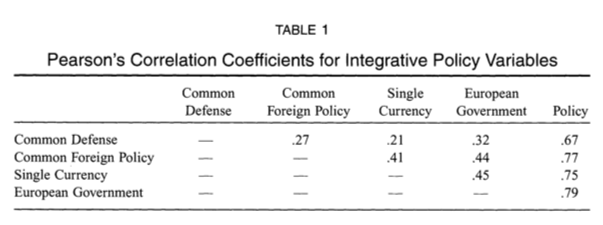

In [12]:
# Original Table from paper for Comparison.
Image(filename='papers/Table1.png')

While the formatting is a little tricky to read, hopefully you should be able to make out that the results achieved are close to those in the original paper.

### Explanatory Variables

In the paper the author defines 5 explanatory variables: 

* Cognitive Mobilization
* Political Values
* Utilitarian Appraisals of Integrative Policy
* Class Partisanship
* Support for Government

In this section we'll explain how we recreate each of these and expose them to Python.

At present all code is being tested against Eurobarometer 30, the data needed to create Table 1. This is done to allow forward progress and to attempt to understand the mutations that will have to be performed on the data before building a pipeline to import all the surveys. 

__***This is very much still in progress and will include notes on limitations of our current approach and where we're currently blocked.***__


##### Cognitive Mobilization
    * "When you get together with friends, would you say you discuss political matters, frequently, occasionally, or never?" (v21)

In [13]:
# Create Dummy Variables for Cognative Motivation. 
Cognitive_Mobilization = data[['v21']]
Cognitive_Mobilization.columns = ['Cognitive Mobilization']
Cognitive_Mobilization = pandas.get_dummies(Cognitive_Mobilization)

Cognitive_Mobilization.head(n=5)

Cognitive Mobilization_FREQUENTLY  Cognitive Mobilization_OCCASIONALLY  \
0                                  0                                    1   
1                                  0                                    1   
2                                  0                                    0   
3                                  0                                    0   
4                                  0                                    1   

   Cognitive Mobilization_NEVER  
0                             0  
1                             0  
2                             1  
3                             1  
4                             0

#### Political Values

This question is defined on p342 of the paper:

>Respondents were asked to choose what should be their nation's goals (first and second choice) 
>from the following list of options: maintaining order; (c) giving the people more say in important 
>government decisions; (c) fighting rising prices; and (d) protecting
>freedom of speech. Respondents choosing (a) or (b) as their first and second
>choices were coded as "materialist." Respondents choosing (b) or (d) as their

Note: Original Paper appears to have a typo, I've had to guess/deduce what is the correct coding.

* Materialist answered as follows to their first and second answers: 
    * (a) maintaining order
    * (c) fighting rising prices
* Postmaterialist answered as follows to their first and second answers:
    * (b) giving the people more say in important government decisions
    * (d) protecting freedom of speech as their first and second choice

Source Question:(v63/v64)
Referenced Book: http://press.princeton.edu/titles/4514.html

Post Materialism var available in 19 of the Eurobarometer polls as variable. (See data/scratch/post-materialism-list for list)

In [14]:
# Create Variables for Political Values. 

Political_Values = data[['v63' , 'v64']]
Political_Values.columns = ['Pol_val_1', 'Pol_val_2']
Political_Values = pandas.get_dummies(Political_Values)

def is_materialist(x):
    order = False
    prices = False
    if (x['Pol_val_1_MAINTAIN ORDER']) or (x['Pol_val_2_MAINTAIN ORDER']):
        order = True
    if (x['Pol_val_1_FIGHT RISING PRICES']) or (x['Pol_val_2_FIGHT RISING PRICES']):
        prices = True
    if (order == True) and (prices == True):
        return 1 

def is_postmaterialist(x):
    say = False
    freedom = False
    if (x['Pol_val_1_PEOPLE MORE SAY']) or (x['Pol_val_2_PEOPLE MORE SAY']):
        say = True
    if (x['Pol_val_1_FREEDOM OF SPEECH']) or (x['Pol_val_2_FREEDOM OF SPEECH']):
        freedom = True
    if (say == True) and (freedom == True):
        return 1 
    
Political_Values['materialist'] = Political_Values.apply(is_materialist, axis=1)
Political_Values['post-materialist'] = Political_Values.apply(is_postmaterialist, axis=1)
Political_Values[['materialist','post-materialist']].head(5)

materialist  post-materialist
0          NaN               1.0
1          NaN               NaN
2          NaN               NaN
3          NaN               1.0
4          NaN               1.0

#### Utilitarian Appraisals of Integrative Policy
    
>"I identified respondents according to occupational skill level, income level, education level, and residence."

##### Occupational skill level (v696)

From the paper:

>I constructed occupational dummy variables for manual laborers, unemployed citizens, executives,
 and professionals.
 
Accompanying Footnote:

>The occupational dummy variables are coded according to the categories reported in the Euro-
 barometers. Eurobarometer surveys beginning in 1989 adopted more specific categories than those
 prior to 1989. For these later surveys, I combined occupational categories so that they matched those
 of the pre-1989 surveys.

There's very limited information on how the author recoded the post 1989 data. 
(A 1995 Paper mentioned is from before DCU & Trinity archives.)

I'm unsure how to procede. The categories in the data are:

* SELF EMPLOYED
    * FARMER
    * FISHERMAN
    * PROFESSIONAL
    * OWNERS SHOPS COMPANIES
* EMPLOYED
    * EMPLOYED PROFESSIONAL
    * GENERAL MANAGEMENT
    * MIDDLE MANAGEMENT
    * OTHER OFFICE EMPLOYEES
    * NON-OFFICE EMPLOYEES
    * SUPERVISORS
    * SKILLED MANUAL WORKER
    * OTHER MANUAL WORKER
* WITHOUT PAID WORK
    * RETIRED
    * HOUSEWIFE NOT EMPLOYED
    * STUDENT
    * MILITARY SERVICE
    * UNEMPLOYED TEMPORARLY
    
(Information taken from codebook, direct link here: https://goo.gl/N0TnX5) 

* Are farmers and fishermen manual laborers?
* Is there a good definition of Executive?
* Do all people 'without paid work' count as Unemployed?

**NO CODE WRITTEN AS YET**

##### Income Level (v695)

From the paper: 
>I constructed dummy variables for four levels of income and for four levels of education


In [15]:
Income = data[['v695']]
Income.columns = ['Income']
levels = ['low','low-mid','high-mid','high']
Income['Income'].cat.categories = levels
Income = pandas.get_dummies(Income)
Income.head(5)

Income_low  Income_low-mid  Income_high-mid  Income_high
0           0               0                0            0
1           0               0                1            0
2           1               0                0            0
3           1               0                0            0
4           1               0                0            0

##### Education Level (v685)

From the paper: 
>I constructed dummy variables for four levels of income and for four levels of education

The authour defines education level from v685 as:

| Level | age       
| :- |-------------: 
|low| 14 or lower 
| low-mid | 15-19 
| high-mid | 20-21
| high | 22+



Case where respondant is 'still studying' is undefined by the author.

In [25]:
Education = data[['v685','v690']]
Education.columns = ['Education','Age']
levels = ['low','low-mid','high-mid','high']

def low_ed(x):
    if x['Education'] == 'UP TO 14 YEARS':
        return 1
    elif (x['Education'] == 'STILL STUDYING') and (x['Age'] < 15):
        return 1

def low_mid_ed(x):
    low_mid_ed = [
        '15 YEARS',
        '16 YEARS',
        '17 YEARS',
        '18 YEARS',
        '19 YEARS']
    if x['Education'] in low_mid_ed:
        return 1
    elif (x['Education'] == 'STILL STUDYING') and (x['Age'] in [15, 16, 17, 18, 19]):
        return 1

def high_mid_ed(x):
    high_mid_ed = ['20 YEARS', '21 YEARS']
    if x['Education'] in high_mid_ed:
        return 1
    elif (x['Education'] == 'STILL STUDYING') and (x['Age'] in [20, 21]):
        return 1

def high_ed(x):
    if x['Education'] == '22 YEARS UND OLDER':
        return 1
    elif (x['Education'] == 'STILL STUDYING') and (x['Age'] > 21):
        return 1



Education['low'] = Education.apply(low_ed, axis=1)
Education['low-mid'] = Education.apply(low_mid_ed, axis=1)
Education['high-mid'] = Education.apply(high_mid_ed, axis=1)
Education['high'] = Education.apply(high_ed, axis=1)
# Education.head(5)

Education.loc[Education['Education'] == 'STILL STUDYING']

Education       Age  low  low-mid  high-mid  high
22     STILL STUDYING        30  NaN      NaN       NaN   1.0
35     STILL STUDYING        18  NaN      1.0       NaN   NaN
66     STILL STUDYING        28  NaN      NaN       NaN   1.0
67     STILL STUDYING        23  NaN      NaN       NaN   1.0
73     STILL STUDYING        19  NaN      1.0       NaN   NaN
74     STILL STUDYING        19  NaN      1.0       NaN   NaN
93     STILL STUDYING  15 YEARS  NaN      NaN       NaN   1.0
129    STILL STUDYING        25  NaN      NaN       NaN   1.0
166    STILL STUDYING        17  NaN      1.0       NaN   NaN
188    STILL STUDYING        27  NaN      NaN       NaN   1.0
194    STILL STUDYING        19  NaN      1.0       NaN   NaN
199    STILL STUDYING        27  NaN      NaN       NaN   1.0
202    STILL STUDYING        25  NaN      NaN       NaN   1.0
216    STILL STUDYING        25  NaN      NaN       NaN   1.0
234    STILL STUDYING        20  NaN      NaN       1.0   NaN
242    STILL STUDYING        26  NaN      NaN       NaN   1.0
251    STILL STUDYING        20  NaN      NaN       1.0   NaN
266    STILL STUDYING        29  NaN      NaN       NaN   1.0
269    STILL STUDYING        18  NaN      1.0       NaN   NaN
272    STILL STUDYING        24  NaN      NaN       NaN   1.0
273    STILL STUDYING        28  NaN      NaN       NaN   1.0
274    STILL STUDYING        27  NaN      NaN       NaN   1.0
284    STILL STUDYING        25  NaN      NaN       NaN   1.0
294    STILL STUDYING        17  NaN      1.0       NaN   NaN
308    STILL STUDYING        16  NaN      1.0       NaN   NaN
312    STILL STUDYING        18  NaN      1.0       NaN   NaN
326    STILL STUDYING        21  NaN      NaN       1.0   NaN
327    STILL STUDYING        25  NaN      NaN       NaN   1.0
335    STILL STUDYING        26  NaN      NaN       NaN   1.0
357    STILL STUDYING        16  NaN      1.0       NaN   NaN
...               ...       ...  ...      ...       ...   ...
11346  STILL STUDYING        19  NaN      1.0       NaN   NaN
11347  STILL STUDYING        21  NaN      NaN       1.0   NaN
11360  STILL STUDYING        25  NaN      NaN       NaN   1.0
11381  STILL STUDYING        17  NaN      1.0       NaN   NaN
11409  STILL STUDYING        19  NaN      1.0       NaN   NaN
11425  STILL STUDYING        22  NaN      NaN       NaN   1.0
11436  STILL STUDYING        17  NaN      1.0       NaN   NaN
11471  STILL STUDYING        23  NaN      NaN       NaN   1.0
11481  STILL STUDYING        22  NaN      NaN       NaN   1.0
11503  STILL STUDYING        17  NaN      1.0       NaN   NaN
11516  STILL STUDYING        16  NaN      1.0       NaN   NaN
11521  STILL STUDYING        27  NaN      NaN       NaN   1.0
11523  STILL STUDYING  15 YEARS  NaN      NaN       NaN   1.0
11540  STILL STUDYING        17  NaN      1.0       NaN   NaN
11543  STILL STUDYING        21  NaN      NaN       1.0   NaN
11545  STILL STUDYING  15 YEARS  NaN      NaN       NaN   1.0
11565  STILL STUDYING        19  NaN      1.0       NaN   NaN
11587  STILL STUDYING        21  NaN      NaN       1.0   NaN
11595  STILL STUDYING  15 YEARS  NaN      NaN       NaN   1.0
11623  STILL STUDYING        20  NaN      NaN       1.0   NaN
11639  STILL STUDYING        16  NaN      1.0       NaN   NaN
11649  STILL STUDYING        16  NaN      1.0       NaN   NaN
11671  STILL STUDYING        21  NaN      NaN       1.0   NaN
11673  STILL STUDYING        18  NaN      1.0       NaN   NaN
11698  STILL STUDYING  15 YEARS  NaN      NaN       NaN   1.0
11735  STILL STUDYING        26  NaN      NaN       NaN   1.0
11765  STILL STUDYING        21  NaN      NaN       1.0   NaN
11779  STILL STUDYING        17  NaN      1.0       NaN   NaN
11780  STILL STUDYING        17  NaN      1.0       NaN   NaN
11782  STILL STUDYING        24  NaN      NaN       NaN   1.0

[1266 rows x 6 columns]

##### Residence (v732)

From the paper: 
>I constructed a dummy variable for respondents living in regions bordering on EU member-states. (v732)
 
This is available as a variable in the dataset with no modification.

This is only true of Eurobarmeter 30 & 31. There is also a 'region' variable that may allow this to be recoded from the other sets. 

In [17]:
Region = data[['v732']]
Region.columns = ['REGION']
Region = pandas.get_dummies(Region)
Region.head(5)

REGION_FRONTIER ZONE  REGION_NON-FRONTIER
0                     0                    1
1                     1                    0
2                     1                    0
3                     1                    0
4                     1                    0

##### Class Partisanship

>"If there were a general election tomorrow, which party would you support?" (v687)
    
To encode this variable we require party affiliation and country, and a mapping to either proletariat or bourgeois. 

Party and country can be taken directly from the survey. (v5, v687)

In [18]:
# Create Variable for Class Partisanship
Class_Partisanship = data[['v5','v687']]
Class_Partisanship.columns = [
    'Nation_1', 
    'Party']

For the evaluation of proletariat or bourgeois from footnote 21/22, page 344 of the paper:

>The proletariat parties were (France) Communist Party, Socialist Party, and Lutte Ouvriere; (Belgium) Communist Party and Socialist Parties Walloon and Flemish; (The Netherlands) CPN and PVDA; (West Germany) Social Democratic Party; (Italy) PCI and PSI; (Luxembourg) KP and LSAP;(Denmark) DKP, SD, SPP, and Socialist Left; (Ireland) Labour Party and Workers' Party; (United Kingdom) Labour Party; (Greece) KKE, KKE international, and PA.SO.K; (Spain) PCI and PSOE; (Portugal) CDU and PSP.

>The bourgeois parties were (France) RPR and UDF; (Belgium) PRL and Liberal Parties- Walloon and Flemish; (The Netherlands) CDA, and VVD; (West Germany) CDU/CSU and FDP; (Italy) CD and PLI; (Denmark) KF; (United Kingdom) Conservative Party; (Spain) CP; (Portugal) PDC and CDS. I was not able to identify a bourgeois party in Luxembourg or Ireland.

I took the values from the code book (https://goo.gl/d1c02y) and mapped them to the parties mentioned in the footnote.

In [19]:
# Can we use a numerical rather than classification approach, 
# all parties lower than X = 'Prol Parties'?

proletariat = {
    'FRANCE': [5, 10, 20],
    'BELGIUM': [10, 20, 21],
    'NETHERLANDS': [10, 20],
    'GERMANY': [20],
    'ITALY': [10, 20],
    'LUXEMBOURG': [10, 20],
    'DENMARK': [5, 10, 15, 20],
    'IRELAND': [20, 21],
    'UNITED KINGDOM': [20],
    'GREECE': [10, 11],
    'SPAIN': [10, 20],
    'PORTUGAL': [10, 20]
}

bourgeois = {
    'FRANCE': [60, 70],
    'BELGIUM': [53, 41],
    'NETHERLANDS': [63, 70],
    'GERMANY': [40, 60],
    'ITALY': [60, 70],
    'LUXEMBOURG': [],
    'DENMARK': [61],
    'IRELAND': [],
    'UNITED KINGDOM': [60],
    'GREECE': [],
    'SPAIN': [70],
    'PORTUGAL': [60, 70]
}

def is_proletariat(x):
    if x['Party'] in proletariat[x['Nation_1']]:
            return 1
        
def is_bourgeois(x):
    if x['Party'] in bourgeois[x['Nation_1']]:
            return 1

**Some caveats:**

The 'Liberal Party Walloon' is mentioned in the paper but missing from the test data. (It may be present in other years.)

The paper references United Kingdom, where the survey data divides between GB and NI. In the code I have used the GB codes as that is where the parties mentioned are found.

While the paper states "I was not able to identify a bourgeois party in Luxembourg or Ireland." It fails to note Greece, which it silently omits from the list of countries with bourgeois parties. I have handled it the same was as Luxemburg and Greece. 

For spain it lists 'CP' as the bourgeois party, this name is not found in the survey data. A review suggests it could mean "Coalición Popular", a group that included the AP (Popular Alliance) a group which is in the data. I have included this assumption in the code.

In [20]:
Class_Partisanship['proletariat'] = Class_Partisanship.apply(is_proletariat, axis=1)
Class_Partisanship['bourgeois'] = Class_Partisanship.apply(is_bourgeois, axis=1)
Class_Partisanship.head(n=5)

# Why were the German Comunist part excluded from anaylsis? 
# Can we use a numerical rather than classification approach, 
# all parties lower than X = 'Prol Parties'?
# Are parties coded consistently across surveys? 

Nation_1 Party  proletariat  bourgeois
0  GERMANY    60          NaN        1.0
1  GERMANY    20          1.0        NaN
2  GERMANY    20          1.0        NaN
3  GERMANY    20          1.0        NaN
4  GERMANY    60          NaN        1.0

##### Support for Government

>"If there were a general election tomorrow, which party would you support?" (v687)

In this case the result should be re-coded as a dummy variable 1 if respondent supported the Prime Minister's Party, President in the case of France.

__***I need to find a dataset which will tell me the Prime Minister's party on a given date. This is an open problem.***__

**NO CODE WRITTEN AS YET**

### Control Variables. 

** Age:** Age is coded as the self-reported number. (v690)

In [21]:
age = data[['v690']]
age.columns = ['Age']
age.head(5)

Age
0  57
1  46
2  79
3  79
4  59

** Gender:** The variable Female is a dummy variable coded 1 for female and 0 for male (v689)

In [22]:
Gender = data[['v689']]
Gender = pandas.get_dummies(Gender)
Gender.columns = ['Male','Female']
Gender.head(5)

Male  Female
0     1       0
1     0       1
2     0       1
3     0       1
4     0       1

** Occupation:** (v696) This has a number of the same issues listed in the "Utilitarian-Appraisals-of-Integrative-Policy" section.

In [23]:
Occupation = data[['v696']]
Occupation.columns = ['Occupation']
Occupation.head(5)

Occupation
0                  FARMER
1    NON-OFFICE EMPLOYEES
2  HOUSEWIFE NOT EMPLOYED
3                 RETIRED
4                 RETIRED